In [1]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage import interpolation
from skimage.restoration import unwrap_phase
from mpl_toolkits.axes_grid1 import AxesGrid

In [2]:
mask = np.load("mask.npy")
pacbed = np.load("pacbed trim.npy")
slices = np.load("trotter intensity.npy")

Text(0.5, 1.0, 'Trotter')

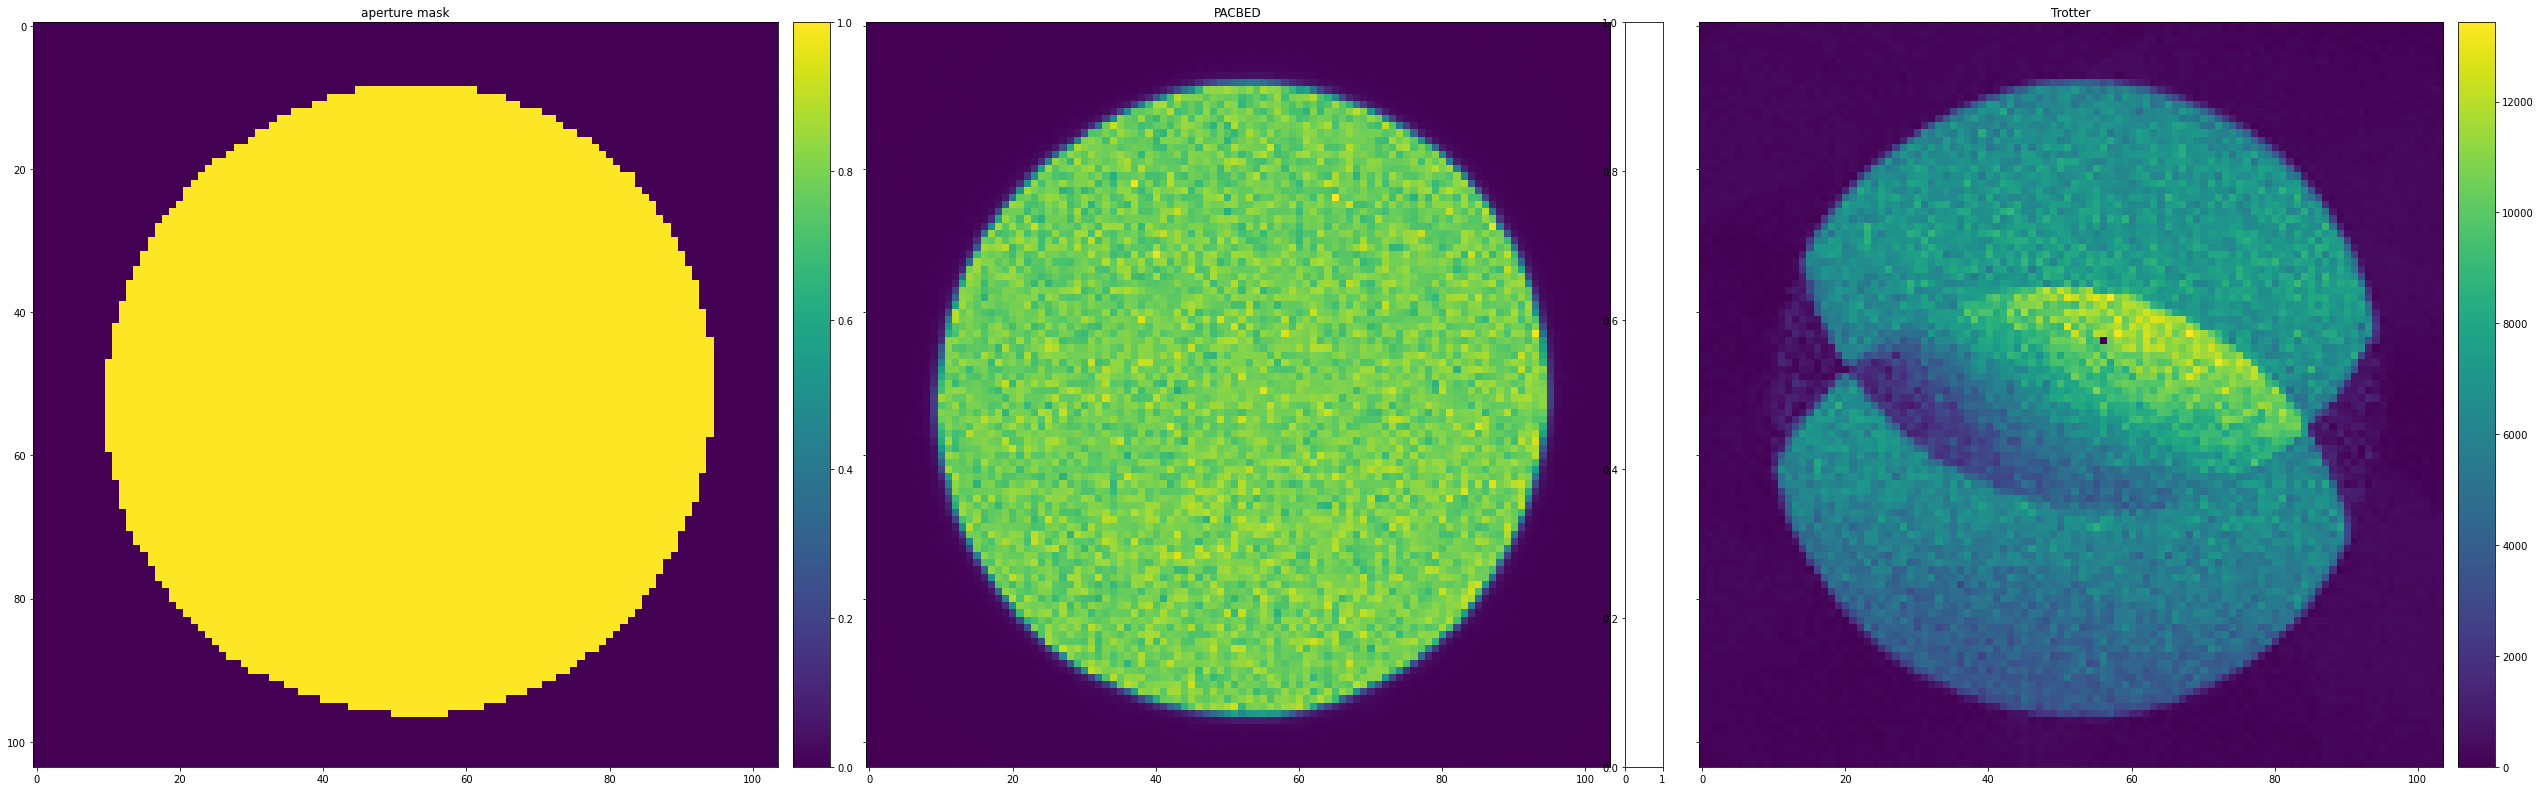

In [3]:
fig =plt.figure(1, figsize=(150, 50))
grid=AxesGrid(fig, 236, nrows_ncols=(1,3),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(mask, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("aperture mask")
im=grid[1].imshow(pacbed, cmap=plt.cm.viridis)
grid[1].set_title("PACBED")
im=grid[2].imshow(slices, cmap=plt.cm.viridis)
grid.cbar_axes[2].colorbar(im)
grid[2].set_title("Trotter")

In [4]:
def ShiftDisk(frame,dx,dy):
    expanded = np.zeros((frame.shape[0]*5,frame.shape[1]*5), frame.dtype)
    expanded[2*frame.shape[0]:3*frame.shape[0],2*frame.shape[1]:3*frame.shape[1]]=frame
    reci_frame=np.fft.fftshift(np.fft.fft2(expanded))
    x_start = -int(expanded.shape[1]/2)
    y_start = -int(expanded.shape[0]/2)
    x_end = x_start + expanded.shape[1]
    y_end = y_start + expanded.shape[0]
    X, Y = np.meshgrid(np.arange(x_start, x_end),np.arange(y_start,y_end))
    X=X*(1.0/expanded.shape[1]) 
    Y=Y*(1.0/expanded.shape[0])
    reci_frame=reci_frame*np.exp(-2j*np.pi*(dx*X+dy*Y))
    expanded = np.real(np.fft.ifft2(np.fft.ifftshift(reci_frame)))
    return expanded[2*frame.shape[0]:3*frame.shape[0],2*frame.shape[1]:3*frame.shape[1]]
def ShiftDiskFast(frame,dx,dy):
    #the expanded part should be large enough.
    x_shift = int(np.round(dx))
    y_shift = int(np.round(dy))
    if (np.abs(x_shift)>=frame.shape[1])|(np.abs(y_shift)>=frame.shape[0]):
        return np.zeros((frame.shape[0],frame.shape[1]), frame.dtype)
    else:
        expanded = np.zeros((frame.shape[0]*3,frame.shape[1]*3), frame.dtype)
        expanded[frame.shape[0]:2*frame.shape[0],frame.shape[1]:2*frame.shape[1]]=frame
        return expanded[(frame.shape[0]-y_shift):(2*frame.shape[0]-y_shift),(frame.shape[1]-x_shift):(2*frame.shape[1]-x_shift)]

In [5]:
def GeneTrotter(params, pacbed):
    dx = params[0]*np.cos(params[1])
    dy = params[0]*np.sin(params[1])
    pacbed_l = ShiftDisk(pacbed,-dx,-dy)
    pacbed_r = ShiftDisk(pacbed,dx,dy)    
    return (pacbed_l + pacbed_r)*pacbed
def GeneFastTrotter(params, pacbed):
    dx = params[0]*np.cos(params[1])
    dy = params[0]*np.sin(params[1])
    pacbed_l = np.float32(ShiftDiskFast(pacbed,-dx,-dy))
    pacbed_r = np.float32(ShiftDiskFast(pacbed,dx,dy)) 
    return (pacbed_l + pacbed_r)*pacbed
def targetFun(params, pacbed, slices):
    trotter = GeneTrotter(params, pacbed)
    return -cv2.matchTemplate(np.float32(slices), np.float32(trotter), cv2.TM_CCOEFF_NORMED)[0, 0]
def targetGFun(params, pacbed, slices):
    trotter = GeneTrotter(params, pacbed)
    gradient1 = np.sqrt(np.sum(np.square(np.abs(np.gradient(slices))), axis =0))
    gradient2 = np.sqrt(np.sum(np.square(np.abs(np.gradient(trotter))), axis =0))
    return -cv2.matchTemplate(np.float32(gradient1), np.float32(gradient2), cv2.TM_CCOEFF_NORMED)[0, 0]
def targetGTFun(params, pacbed, mask, slices):
    trotter = GeneTrotter(params, pacbed)
    mtrotter = GeneFastTrotter(params, mask)
    trotter[np.where(mtrotter>1.0)] = 0
    return -cv2.matchTemplate(np.float32(slices), np.float32(trotter), cv2.TM_CCOEFF_NORMED)[0, 0]

In [6]:
params = np.asarray([29.6, -1.44])
trotter = GeneTrotter(params, pacbed)
new_mask = GeneFastTrotter(params, mask)
mtrotter = trotter.copy()
mtrotter[np.where(new_mask>1.0)] = 0

Text(0.5, 1.0, 'Shifted PACBED left')

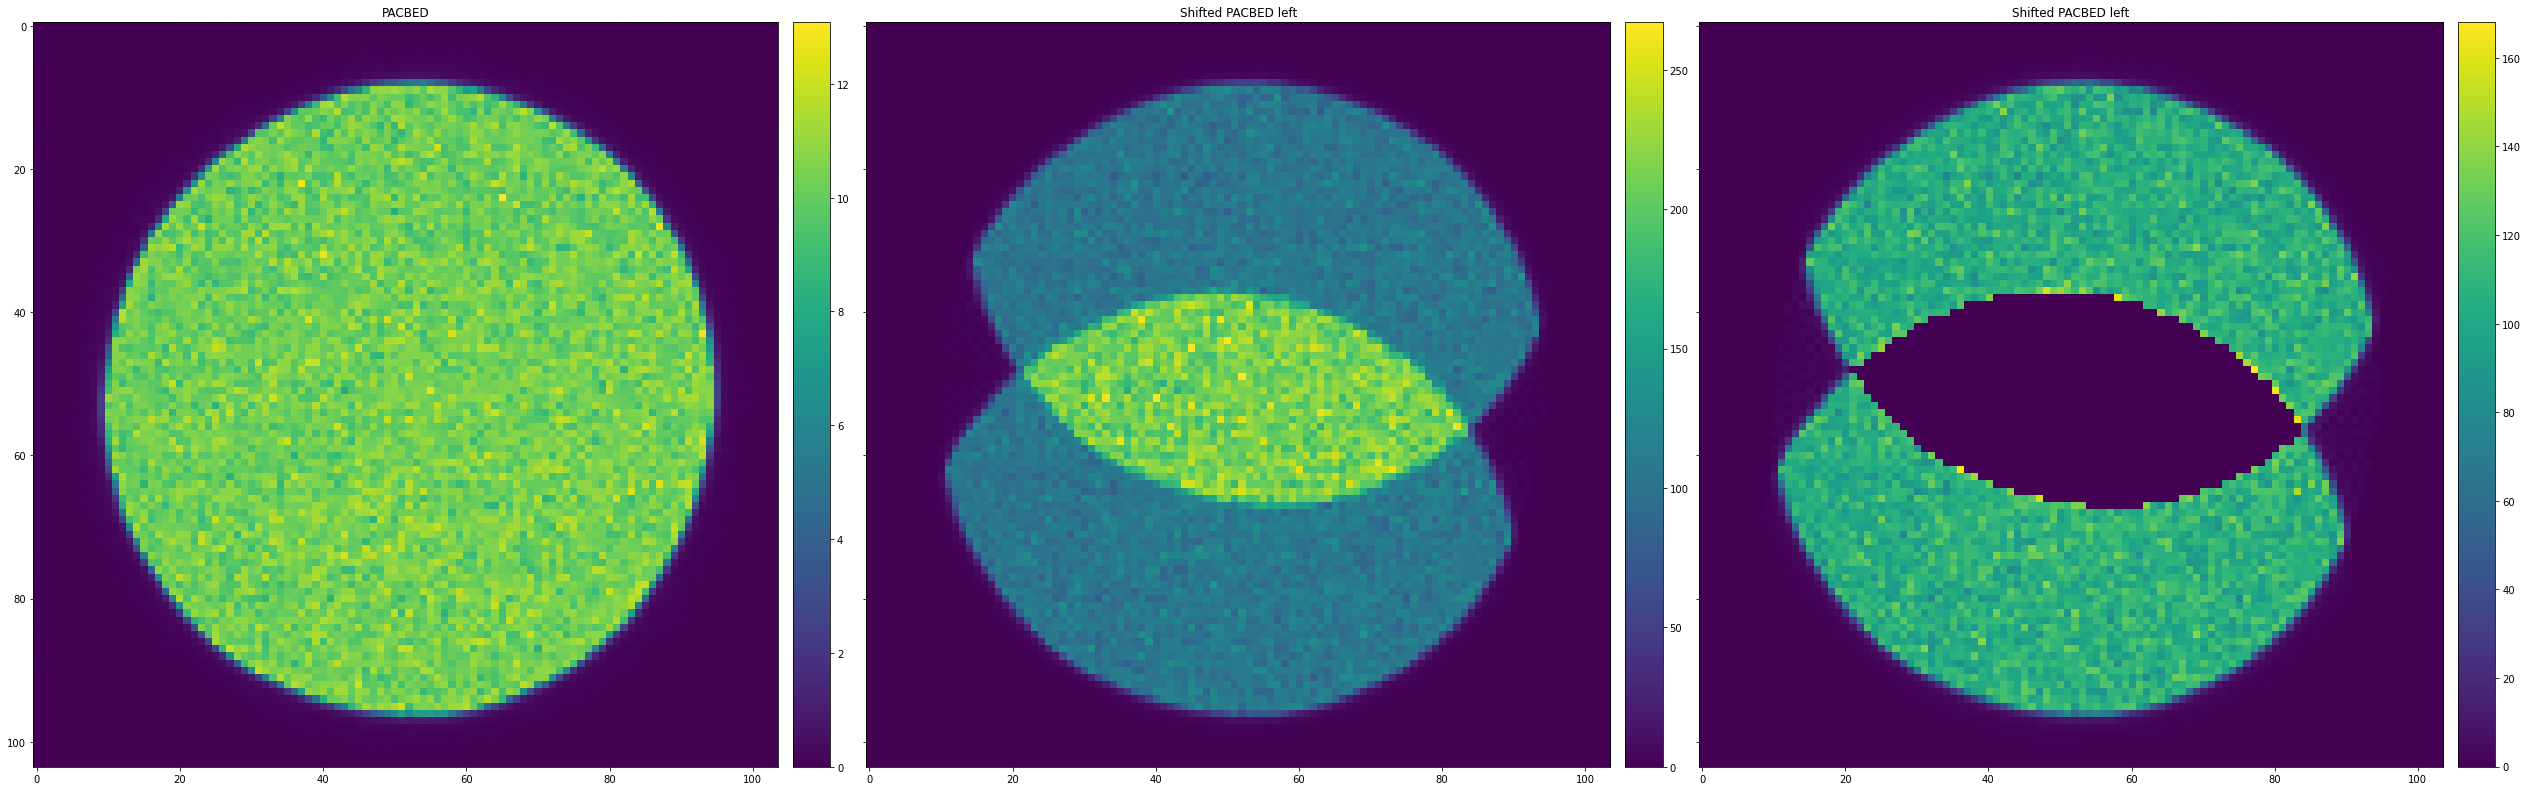

In [7]:
fig =plt.figure(1, figsize=(150, 50))
grid=AxesGrid(fig, 236, nrows_ncols=(1,3),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(pacbed, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("PACBED")
im=grid[1].imshow(trotter, cmap=plt.cm.viridis)
grid.cbar_axes[1].colorbar(im)
grid[1].set_title("Shifted PACBED left")
im=grid[2].imshow(mtrotter, cmap=plt.cm.viridis)
grid.cbar_axes[2].colorbar(im)
grid[2].set_title("Shifted PACBED left")

In [8]:
params = np.asarray([29.6, -1.44])
params = optimize.minimize(targetFun,params,args=(pacbed,slices), method='Nelder-Mead').x

In [9]:
print(params)

[28.82039505 -1.44348625]


In [10]:
params = optimize.minimize(targetGFun,params,args=(pacbed,slices), method='Nelder-Mead').x

In [11]:
print(params)

[28.83283884 -1.43963949]
